In [1]:
import pandas as pd
from jax import vmap
import jax.numpy as jnp
from jax.nn import softmax
import evofr as ef

In [2]:
# Getting data
raw_seq = pd.read_csv("../../rt-from-frequency-dynamics/data/omicron-us-split/omicron-us-split_location-variant-sequence-counts.tsv", sep="\t")
raw_seq = raw_seq[raw_seq.location == "Washington"]
variant_frequencies = ef.VariantFrequencies(raw_seq)

In [3]:
# Defining model
mlr = ef.MultinomialLogisticRegression(tau=4.2)

In [4]:
# Defining inference method
inference_method = ef.InferFullRank(iters=10_000, lr=0.01, num_samples=100)

In [5]:
# Fitting model
posterior = inference_method.fit(mlr, variant_frequencies)
samples = posterior.samples

In [6]:
def forecast_frequencies(samples, mlr, forecast_L):
    """
    Use posterior beta to forecast posterior frequenicies.
    """
    
    # Making feature matrix for forecasting
    last_T = samples["freq"].shape[1]
    X = mlr.make_ols_feature(start=last_T, stop=last_T + forecast_L)
    
    # Posterior beta
    beta = jnp.array(samples["beta"])
    
    # Matrix multiplication by sample
    dot_by_sample = vmap(jnp.dot, in_axes=(None, 0), out_axes=0)
    logits = dot_by_sample(X, beta) # Logit frequencies by variant
    return softmax(logits, axis=-1)

forecast_L = 30
samples["freq_forecast"] = forecast_frequencies(samples, mlr, forecast_L)

## Plotting results

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 32}

matplotlib.rc('font', **font)

In [8]:
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]


v_colors = ["#56e39f", "#89CFF0", "#C70039",  "#5567aa", "#c5d46f", "#aa34a4", "#808080"]

v_names = ['Delta', 
           'Omicron 21L', 
           'Omicron 21K', 
           'Omicron 22A', 
           'Omicron 22B', 
           'Omicron 22C', 
           'other']
color_map = {v : c for c, v in zip(v_colors, v_names)}

In [9]:
from evofr.plotting import *

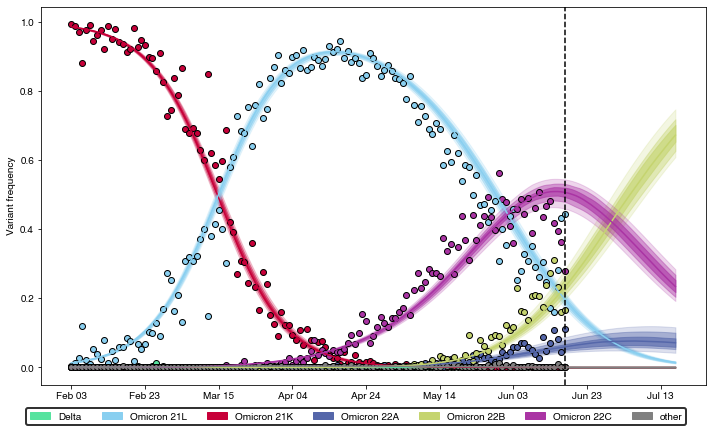

In [10]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

colors = [color_map[v] for v in variant_frequencies.var_names] # Mapping colors to observed variants

# Plot predicted frequencies
plot_posterior_frequency(ax, samples, ps, alphas, colors, forecast=True)
plot_observed_frequency(ax, variant_frequencies, colors) # Plot observed frequencies

ax.axvline(x=len(variant_frequencies.dates)-1, color='k', linestyle='--') # Adding forecast cut off
add_dates_sep(ax, ef.data.expand_dates(variant_frequencies.dates, forecast_L), sep=20) # Adding dates
ax.set_ylabel("Variant frequency") # Making ylabel


# Make legend
patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
legend.get_frame().set_linewidth(2.)
legend.get_frame().set_edgecolor("k")
fig.tight_layout()
fig.subplots_adjust(bottom = 0.1)

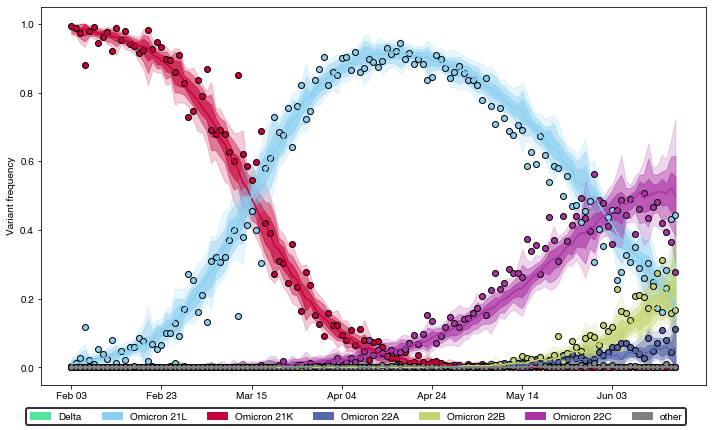

In [11]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

colors = [color_map[v] for v in variant_frequencies.var_names] # Mapping colors to observed variants

# Plot posterior predictive frequency
plot_ppc_frequency(ax, samples, variant_frequencies, ps, alphas, colors)
plot_observed_frequency(ax, variant_frequencies, colors) # Plot observed frequencies
add_dates_sep(ax, variant_frequencies.dates, sep=20) # Adding dates
ax.set_ylabel("Variant frequency") # Making ylabel


# Make legend
patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
legend.get_frame().set_linewidth(2.)
legend.get_frame().set_edgecolor("k")
fig.tight_layout()
fig.subplots_adjust(bottom = 0.1)

Text(0, 0.5, 'Growth advantage')

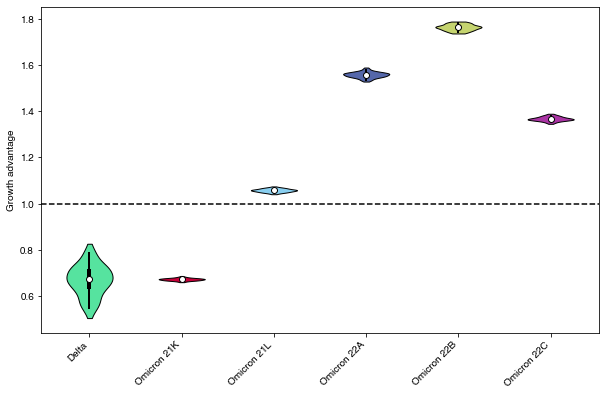

In [12]:
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

plot_growth_advantage(ax, samples, variant_frequencies, ps, alphas, colors)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("Growth advantage")